In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import torchvision
import timm
import torch
import pathlib
from PIL import Image
import matplotlib.pyplot as plt
import einops

In [4]:
image_size = 224
m = timm.create_model(f'vit_base_patch16_{image_size}', pretrained=True)
m.eval();

In [32]:
class ImageNetDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.path = pathlib.Path("imagenet-sample-images/")
        if not self.path.exists():
            !git clone https://github.com/EliSchwartz/imagenet-sample-images.git
        self.files = sorted(list(self.path.glob("*.JPEG")))
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        filename = self.files[i]
        img = Image.open(filename)
        img.load()
        # data = np.asarray(img, dtype="float32") / 255
        return img
    
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        return self.transform(self.dataset[i])

dataset = ImageNetDataset()


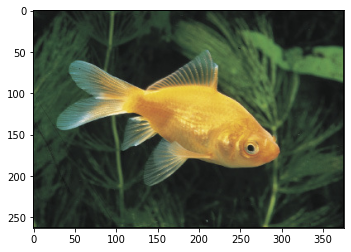

In [24]:
plt.imshow(dataset[1])

In [25]:
resize = torchvision.transforms.Resize((image_size, image_size))
scale_minus_one_one = lambda x: (x * 2) - 1
preprocess = torchvision.transforms.Compose([resize,
                                             torchvision.transforms.ToTensor(),
                                             scale_minus_one_one])

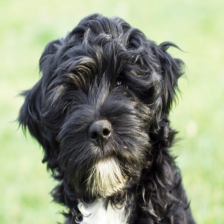

In [26]:
resize(dataset[200])

In [37]:
batch_size = 100
dataloader = torch.utils.data.DataLoader(TransformedDataset(dataset, preprocess), batch_size=batch_size)
batch = next(iter(dataloader))

In [38]:
y, stats = m(batch)

In [90]:
attention = torch.stack(stats["attention"])

In [51]:
# Save ImageNet samples
vit_imagenet_dir = pathlib.Path("../interactive/vit_imagenet")
vit_imagenet_dir.mkdir(parents=True, exist_ok=True)

In [54]:
for i in range(batch_size):
    image = resize(dataset[i])
    image_path = vit_imagenet_dir / f"image_{i:03d}.png"
    image.save(image_path)

FileNotFoundError: [Errno 2] No such file or directory: '../interactive/vit_imagenet/original/image_000.png'

In [91]:
attention = einops.rearrange(attention, "layer batch heads query key -> batch layer heads query key")


In [93]:
import numpy as np

attention_np = attention.numpy()
with open(vit_imagenet_dir / "attention.npy", "wb") as f:
    np.save(f, attention_np)

In [9]:
import numpy as np

with open("../interactive/attention.npy", "rb") as f:
    attention_np = np.load(f)

Untitled.ipynb		       plot_attention.ipynb
ViT_visualization.ipynb        plot_attention_cifar100.ipynb
attention_comparison.ipynb     plot_attention_from_chkpt.ipynb
extract_mathematica.ipynb      plot_attention_from_chkpt_old.ipynb
gaussian.ipynb		       plot_attention_with_data.ipynb
imagenet-sample-images	       plots.ipynb
interactive-export-data.ipynb  sinus_enc_experiment_data.ipynb
jb_evaluation.ipynb


In [10]:

from matplotlib.patches import Ellipse, Rectangle

def reshape_attention_to_plot(attention):
    """Reshape an attention vector into CLS with first column padding and the rest of the squared image."""
    n = attention.shape[0]
    width = int(math.sqrt(n - 1))
    cls_score = attention[0:1]
    image_scores = attention[1:].reshape(width, width)
    first_column_padding = np.ones((width - 1)) * attention.min()
    first_column = np.concatenate([cls_score, first_column_padding])
    return np.concatenate([first_column[:, None], image_scores], axis=1)

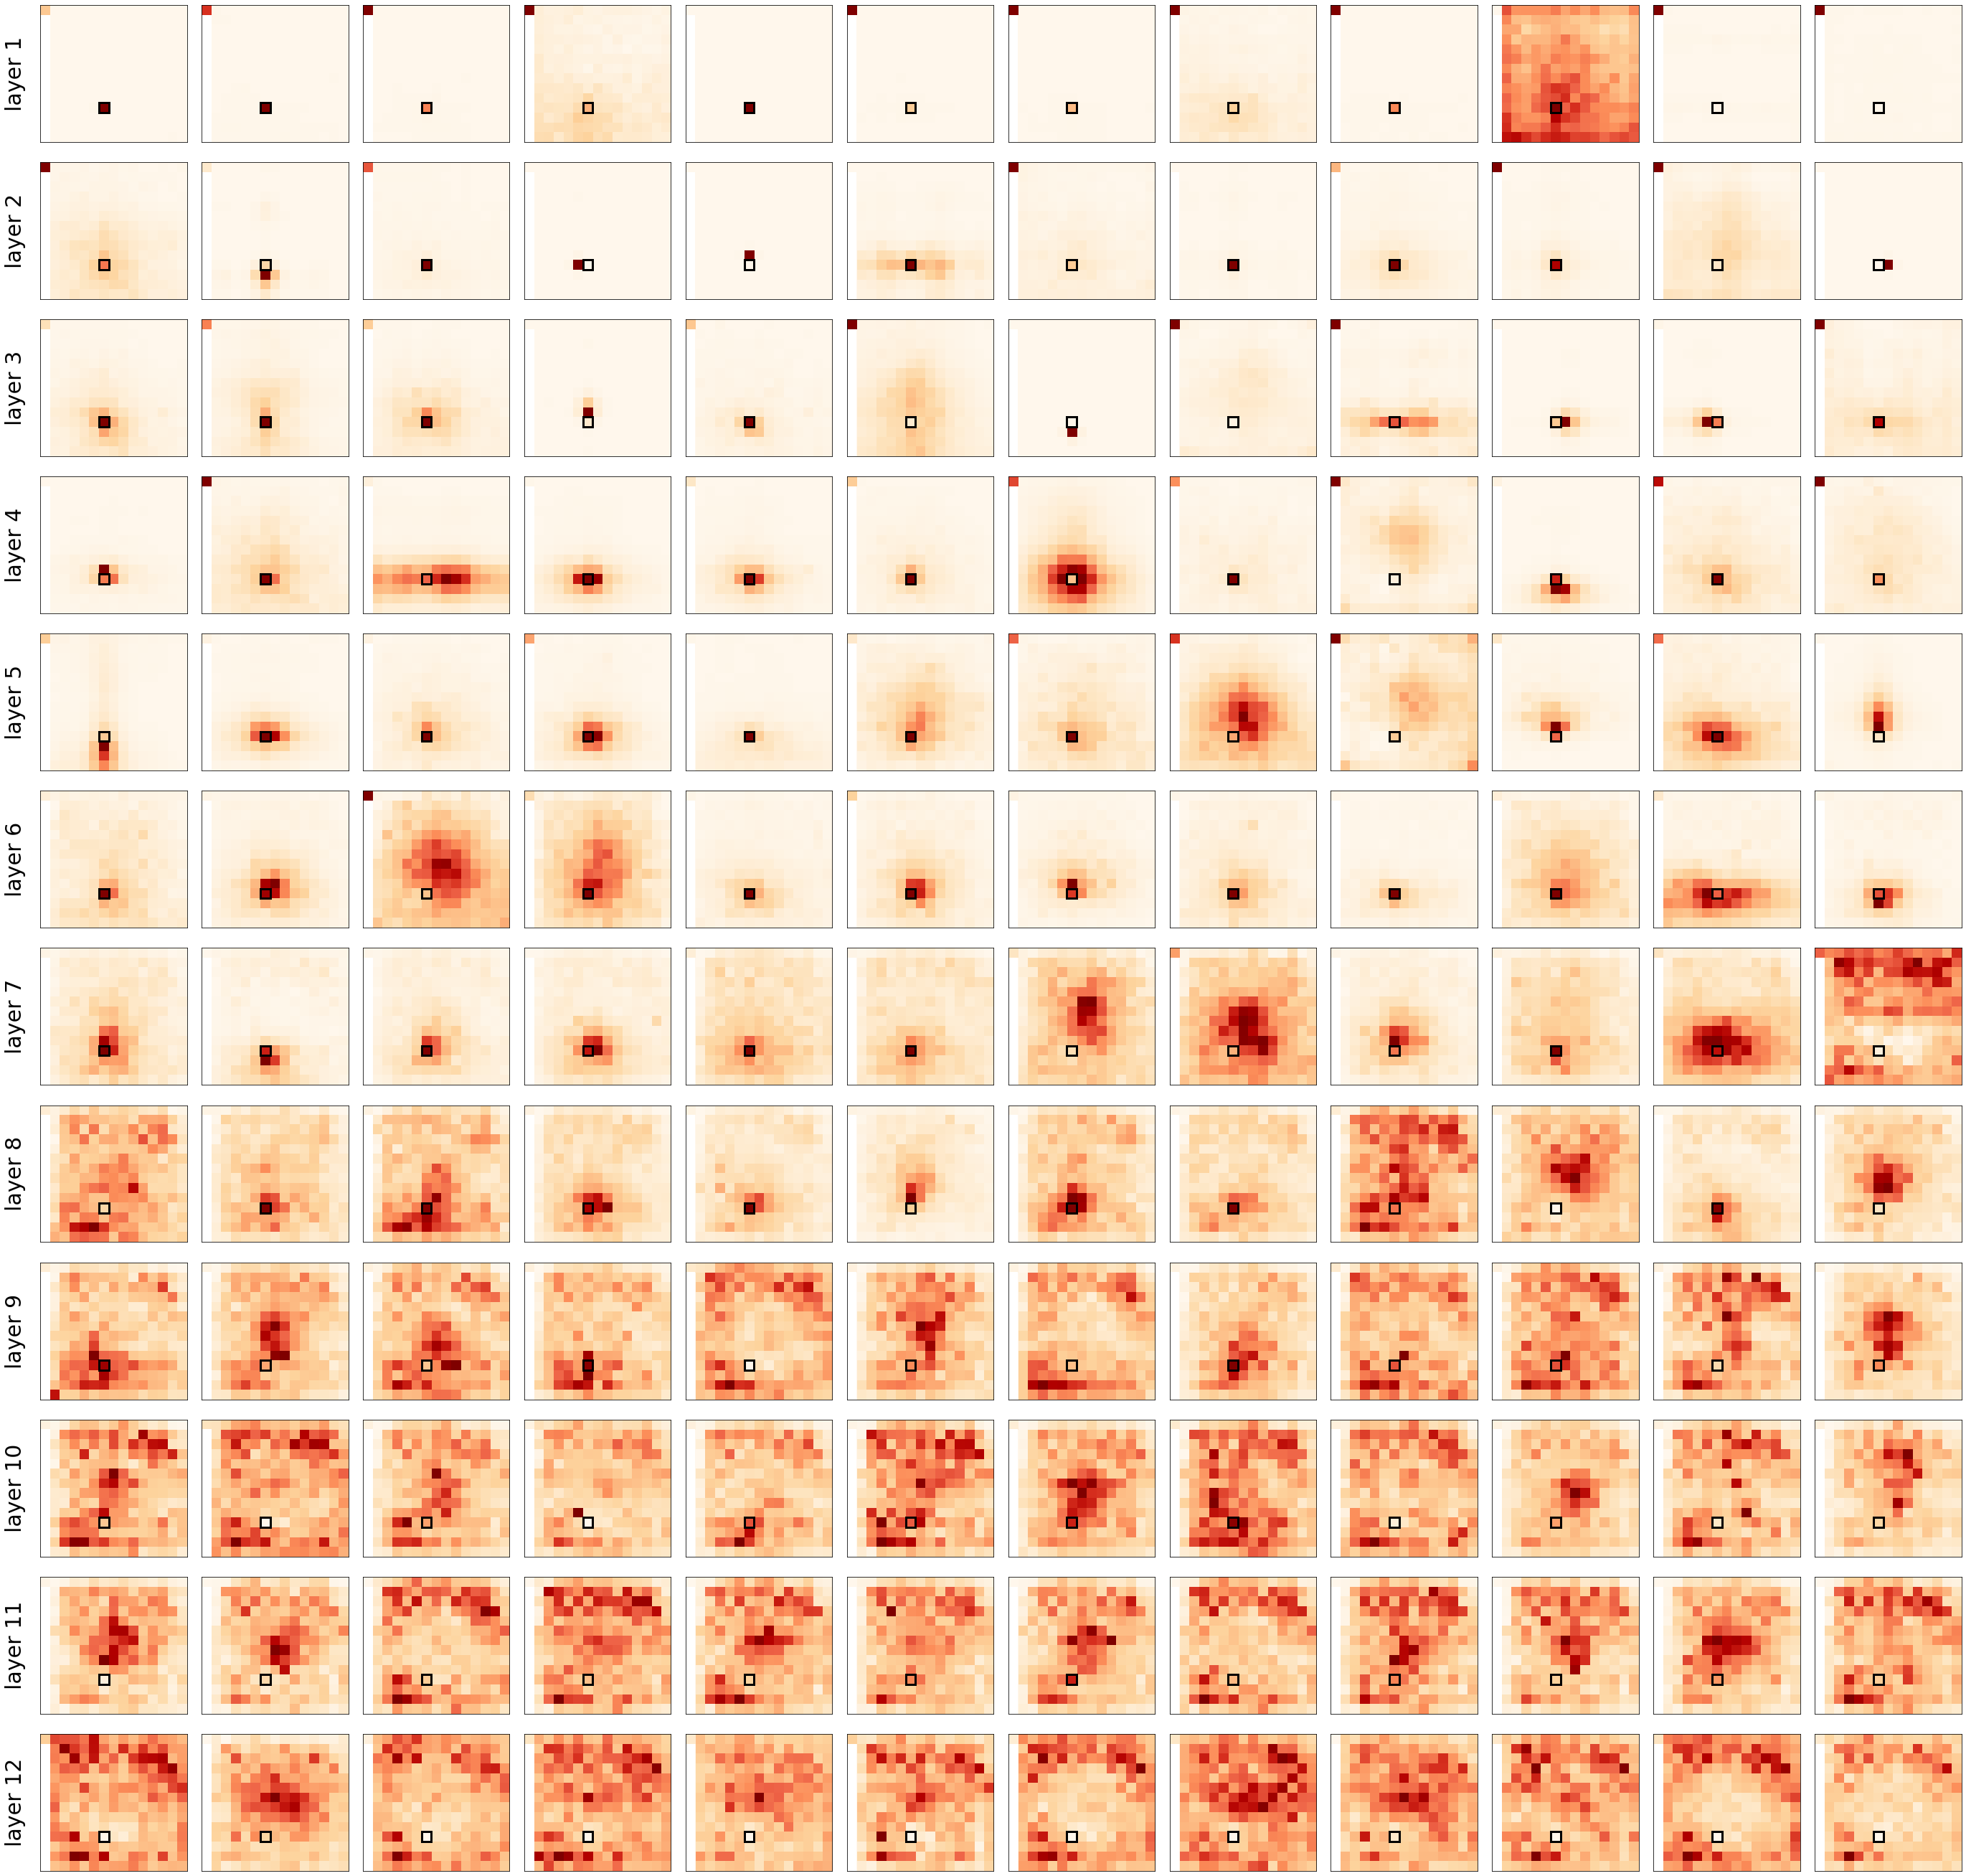

In [14]:

import math

def plot_attentions(attention, *, pixel_x=None, pixel_y=None, cls_token: bool = False):
    if cls_token and (pixel_x is not None or pixel_y is not None):
        raise ValueError("Specify either `cls_token` or pixel position.")
    num_layers, num_heads, num_tokens, _ = attention.shape
    
#     # TODO remove
#     num_layers = 2
#     num_heads = 2
    
    width_and_height = int(math.sqrt(num_tokens - 1))
    f, axes = plt.subplots(
        num_layers, num_heads, 
        figsize=(4 * num_heads, 4 * num_layers)
    )
    
    def remove_ticks(ax):
        ax.tick_params(
                axis="both",
                which="both",
                bottom=False,
                top=False,
                left=False,
                labelbottom=False,
                labelleft=False,
            )
    
    
    
    for layer_idx in range(num_layers):
        for col_idx, head_idx in enumerate(range(num_heads)):
            ax = axes[layer_idx][col_idx]
            if cls_token:
                query_pixel = 0
            else:
                query_pixel = 1 + pixel_y * width_and_height + pixel_x
            attention_probs = attention[layer_idx, head_idx, query_pixel]
            
            ax.imshow(reshape_attention_to_plot(attention_probs), 
                      cmap="OrRd")
            
            
            hide_padding_col = Rectangle(xy=(- 0.5, 0.5), 
                      width=1, 
                      height=width_and_height - 1, 
                      edgecolor=None,  
                      fc='white', 
                      lw=0)
            ax.add_patch(hide_padding_col);
            
            if cls_token:
                query_x, query_y = 0, 0
            else:
                query_x, query_y = 1 + pixel_x, pixel_y
            querry_pix = Rectangle(xy=(query_x - 0.5, query_y - 0.5), 
                                  width=1, 
                                  height=1, 
                                  edgecolor="black",  
                                  fc='None', 
                                  lw=3)
            ax.add_patch(querry_pix);
            
            ax.set_aspect(1)
            remove_ticks(ax)

        axes[layer_idx][0].set_ylabel("layer {}".format(layer_idx + 1), fontsize=30, labelpad=20)
        
    f.subplots_adjust(wspace=0.1, hspace=0.1)
    return f


# fig = plot_attentions(attention_np[0], pixel_x=5, pixel_y=10)
# fig = plot_attentions(attention_np.mean(axis=0), cls_token=True)
fig = plot_attentions(attention_np.mean(axis=0), pixel_x=5, pixel_y=10)
fig.savefig("res.png")

In [ ]:
image_idx, pixel_x, pixel_y = 19, 10, 4

fig = plot_attentions(image_idx, pixel_x, pixel_y);
plt.tight_layout();
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.savefig("attention_qk_qr_i{}_x{}_y{}.pdf".format(image_idx, pixel_x, pixel_y));

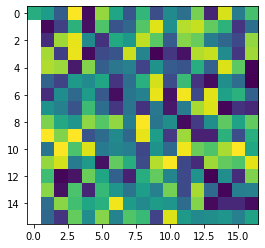

In [77]:


plt.imshow(reshape_attention_to_plot(np.random.rand(1 + 16 * 16)))

hide_padding_col = Rectangle(xy=(- 0.5, 0.5), 
                      width=1, 
                      height=16 - 1, 
                      edgecolor=None,  
                      fc='white', 
                      lw=0)
ax = plt.gca()
ax.add_patch(hide_padding_col);